# Deep Learning Project #2

In [1]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.datasets import make_regression
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import seaborn as sns


# set seed
SEED=42
np.random.seed(SEED)


import warnings
warnings.filterwarnings('ignore')

### Pre processing is not thoroughly explained; minimal changes from the previous proyect and the final dataset is almost alike

In [2]:
#Importing the data
test_df = pd.read_csv('/Users/lfap/Documents/BSE/T2/Deep_learning/Assignment2/mimic_test_los.csv')
train_df = pd.read_csv('/Users/lfap/Documents/BSE/T2/Deep_learning/Assignment1/mimic_train.csv')
extra_df = pd.read_csv('/Users/lfap/Documents/BSE/T2/Deep_learning/Assignment1/MIMIC_diagnoses.csv')

#Copy the data to avoid modifying the original.
train_df1 = train_df.copy()
test_df1 = test_df.copy()
extra_df1 = extra_df.copy()

print('Columns in our dataset: \n',train_df1.columns)

pd.set_option('display.max_columns', None)
train_df1.head(15)

#We cannot use death features to predict death probability
train_df1 = train_df1.drop(['DISCHTIME', 'DOD', 'HOSPITAL_EXPIRE_FLAG', 'DEATHTIME'], axis=1)

Columns in our dataset: 
 Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS'],
      dtype='object')


## Pre processing

In [3]:
#IDs are not needed
train_df1 = train_df1.drop(['icustay_id'], axis=1) 
test_df1 = test_df1.drop(['icustay_id'], axis=1)

# Count the number of hospital stays per 'subject_id' and assign it to a new column
train_df1['NUM_STAYS'] = train_df1.groupby('subject_id')['subject_id'].transform('count')
test_df1['NUM_STAYS'] = test_df1.groupby('subject_id')['subject_id'].transform('count')

train_df1 = train_df1.drop(['subject_id'], axis=1) 
test_df1 = test_df1.drop(['subject_id'], axis=1)

train_df1['DOB'] = pd.to_datetime(train_df1['DOB']).dt.date
train_df1['ADMITDATE'] = pd.to_datetime(train_df1['ADMITTIME']).dt.date
test_df1['DOB'] = pd.to_datetime(test_df1['DOB']).dt.date
test_df1['ADMITDATE'] = pd.to_datetime(test_df1['ADMITTIME']).dt.date

train_df1['AGE'] = train_df1.apply(lambda x: round((x['ADMITDATE'] - x['DOB']).days/365,0), axis=1)
test_df1['AGE'] = test_df1.apply(lambda x: round((x['ADMITDATE'] - x['DOB']).days/365,0),axis=1)

#We will no longer use these columns, the data has been encoded in AGE.
train_df1 = train_df1.drop(['DOB','ADMITDATE'], axis=1) 
test_df1 = test_df1.drop(['DOB','ADMITDATE'], axis=1)

# Calculate the value at the 92th percentile
p92 = train_df1['AGE'].quantile(0.92)
filtered_df = train_df1[train_df1['AGE'] > p92]

train_df1.loc[train_df1['AGE'] > 100, 'AGE'] = 90

In [4]:
# Merge minor religions into 'OTHER'
other_religion_train = (train_df1['RELIGION'].value_counts()).index[train_df1['RELIGION'].value_counts(normalize=True) <= 0.08]
other_religion_test = (test_df1['RELIGION'].value_counts()).index[test_df1['RELIGION'].value_counts(normalize=True) <= 0.08]
train_df1['RELIGION'] = train_df1['RELIGION'].replace(other_religion_train, 'OTHER')
test_df1['RELIGION'] = test_df1['RELIGION'].replace(other_religion_test, 'OTHER')



# Standardize 'LATINO', 'ASIAN' and 'UNKNOWN' categories as before
train_df1.loc[train_df1['ETHNICITY'].str.contains('LATINO', case=False, na=False), 'ETHNICITY'] = 'LATINO'
train_df1.loc[train_df1['ETHNICITY'].str.contains('ASIAN', case=False, na=False), 'ETHNICITY'] = 'ASIAN'
train_df1.loc[train_df1['ETHNICITY'].str.contains('UNABLE|UNKNOWN', case=False, na=False), 'ETHNICITY'] = 'UNKNOWN'
test_df1.loc[test_df1['ETHNICITY'].str.contains('LATINO', case=False, na=False), 'ETHNICITY'] = 'LATINO'
test_df1.loc[test_df1['ETHNICITY'].str.contains('ASIAN', case=False, na=False), 'ETHNICITY'] = 'ASIAN'
test_df1.loc[test_df1['ETHNICITY'].str.contains('UNABLE|UNKNOWN', case=False, na=False), 'ETHNICITY'] = 'UNKNOWN'

ethnicity_counts_train = train_df1['ETHNICITY'].value_counts(normalize=True)
other_ethnicity_train = ethnicity_counts_train[ethnicity_counts_train <= 0.025].index
ethnicity_counts_test = test_df1['ETHNICITY'].value_counts(normalize=True)
other_ethnicity_test = ethnicity_counts_test[ethnicity_counts_test <= 0.025].index

# Replace less common ethnicities with 'OTHER'
train_df1['ETHNICITY'] = train_df1['ETHNICITY'].replace(other_ethnicity_train, 'OTHER')
test_df1['ETHNICITY'] = test_df1['ETHNICITY'].replace(other_ethnicity_test, 'OTHER')

In [5]:
#Encode the gender variable to 0 and 1
train_df1['MALE'] = train_df1['GENDER'].map({'M': 1, 'F': 0})
test_df1['MALE'] = test_df1['GENDER'].map({'M': 1, 'F': 0})

train_df1 = train_df1.drop('GENDER', axis=1)
test_df1 = test_df1.drop('GENDER', axis=1)


#Encode the Admission type variable into an ordinal variable 
# Manual mapping
admiss_type_order = {
    'ELECTIVE': 0,
    'URGENT': 1,
    'EMERGENCY': 2
}

train_df1['ADMISSION_TYPE'] = train_df1['ADMISSION_TYPE'].map(admiss_type_order)
test_df1['ADMISSION_TYPE'] = test_df1['ADMISSION_TYPE'].map(admiss_type_order)


train_df1 = train_df1.drop(['INSURANCE', 'ADMITTIME', 'MARITAL_STATUS','Diff'], axis=1) 
test_df1 = test_df1.drop(['INSURANCE', 'ADMITTIME', 'MARITAL_STATUS','Diff'], axis=1)


train_df2 = train_df1.copy()
test_df2 = test_df1.copy()
# Create a new column 'has_NA' which is 1 if any column in the row has NA, else 0
train_df2['has_NA'] = train_df2.isnull().any(axis=1).astype(int)
test_df2['has_NA'] = test_df2.isnull().any(axis=1).astype(int)

train_df2 = train_df2.drop('DIAGNOSIS', axis=1)
test_df2 = test_df2.drop('DIAGNOSIS', axis=1)
na_columns_num = train_df2.columns[train_df2.isna().any()].tolist()

### Mean imputation

In [6]:
#We need to do this split because our function cannot calculate conditional means for non numerical variables. We will re-merge them back before standarization.
imputation_cols = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean','AGE','MALE']
train_imputation = train_df2[imputation_cols]
test_imputation = test_df2[imputation_cols]


#After imputation we need to concatenate categorical data with the ones that were imputed. For test we dont have the hospital flag feature so a subset of features is needed. 
remaining_cols_train = ['hadm_id', 'LOS','ADMISSION_TYPE', 'ICD9_diagnosis', 'NUM_STAYS', 'has_NA']
remaining_cols_test = ['hadm_id', 'ADMISSION_TYPE', 'ICD9_diagnosis', 'NUM_STAYS', 'has_NA']
#Not ideal

train_remaining = train_df2[remaining_cols_train]
test_remaining = test_df2[remaining_cols_test]

# Calculate conditional means
conditional_means = train_imputation.groupby(['AGE', 'MALE']).mean()

# Copy datasets to avoid changing original dataframes
train_df2_filled = train_imputation.copy()
test_df2_filled = test_imputation.copy()

# Function to safely get conditional mean, or fallback to global mean if not available
def get_conditional_mean(row, column, fallback):
    try:
        # Attempt to return the conditional mean based on AGE and MALE
        return conditional_means.loc[(row['AGE'], row['MALE']), column]
    except KeyError:
        # Fallback if specific group mean is not available
        return fallback

# Fill NAs in training data with conditional means or global mean if conditional mean is not available
for column in na_columns_num:
    global_mean = train_df2_filled[column].mean()  # Calculate global mean for fallback
    condition = train_df2_filled[column].isnull()
    train_df2_filled.loc[condition, column] = train_df2_filled[condition].apply(lambda x: get_conditional_mean(x, column, global_mean), axis=1)

# Do the same for test data, using the conditional means from the training data
for column in na_columns_num:
    global_mean = train_df2_filled[column].mean()  # Use global mean from training data for consistency
    condition = test_df2_filled[column].isnull()
    test_df2_filled.loc[condition, column] = test_df2_filled[condition].apply(lambda x: get_conditional_mean(x, column, global_mean), axis=1)


# Check if there are still any NAs
print('Missing Data in training DS \n' ,train_df2_filled[na_columns_num].isnull().sum().sum())
print('Missing Data in test DS \n', test_df2_filled[na_columns_num].isnull().sum().sum())

Missing Data in training DS 
 0
Missing Data in test DS 
 0


### Merging the imputed dataset with the one hot encoded categoricals

In [7]:
def create_range_col(df, column_names):
    for name in column_names:
        df[f'{name}_Range'] = (df[f'{name}_Max'] - df[f'{name}_Min']) / df[f'{name}_Mean']
        df = df.drop([f'{name}_Max', f'{name}_Min', f'{name}_Mean'], axis=1)
    return df

num_columns = ['HeartRate', 'DiasBP', 'SysBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2', 'Glucose']

train_df2_filled = create_range_col(train_df2_filled, num_columns)
test_df2_filled = create_range_col(test_df2_filled, num_columns)

columns_to_encode = ['FIRST_CAREUNIT', 'ETHNICITY', 'RELIGION']

# Apply get_dummies to only these columns
dummies_train = pd.get_dummies(train_df2[columns_to_encode], drop_first=False)
dummies_test = pd.get_dummies(test_df2[columns_to_encode], drop_first=False)

# # Concatenate the new dummy variables to the original DataFrame
train_df2 = pd.concat([train_df2, dummies_train], axis=1)
train_df2 = train_df2.drop(['FIRST_CAREUNIT','RELIGION','ETHNICITY'], axis=1)

test_df2 = pd.concat([test_df2, dummies_test], axis=1)
test_df2 = test_df2.drop(['FIRST_CAREUNIT','RELIGION','ETHNICITY'], axis=1)


train_df2_final = pd.concat([train_remaining, train_df2_filled, dummies_train], axis=1)
test_df2_final = pd.concat([test_remaining, test_df2_filled, dummies_test], axis=1)

### Extra data

In [8]:
icd9_codes_grouped = extra_df1.groupby('HADM_ID')['ICD9_CODE'].agg(list).reset_index()

lengths = icd9_codes_grouped['ICD9_CODE'].apply(len)

# Find the maximum length
max_length = lengths.max()

# Expand the 'ICD9_CODE' lists into separate columns
expanded_codes = icd9_codes_grouped['ICD9_CODE'].apply(pd.Series)

# Rename the columns to 'CODE + num' until 39 (max num of codes in any hospital stay)
expanded_codes.columns = [f'CODE{i+1}' for i in expanded_codes.columns]

# Join the expanded columns back to the original DataFrame
icd9_codes_grouped = pd.concat([icd9_codes_grouped, expanded_codes], axis=1)
icd9_codes_grouped = icd9_codes_grouped.drop('ICD9_CODE', axis=1)


# Merge the DataFrames on 'hadm_id' and 'HADM_ID'
merged_train_df = pd.merge(train_df2_final, icd9_codes_grouped, left_on='hadm_id', right_on='HADM_ID', how='inner')
merged_test_df = pd.merge(test_df2_final, icd9_codes_grouped, left_on='hadm_id', right_on='HADM_ID', how='inner')

In [9]:
#List of code columns to be encoded
code_columns = [f'CODE{i}' for i in range(1, 40)]

# Initialize the TargetEncoder
encoder = ce.TargetEncoder(cols=code_columns, smoothing=70) #Submitted a few runs to improve the smoothing param.

# Fit the encoder using the training data
encoder.fit(merged_train_df[code_columns], merged_train_df['LOS'])

# Transform the code columns in the training and test data
train_df_encoded = encoder.transform(merged_train_df[code_columns])
test_df_encoded = encoder.transform(merged_test_df[code_columns])

merged_train_df.update(train_df_encoded)
merged_test_df.update(test_df_encoded)

##------------------------------------------------------------------------------------------------------

#Final details on our data
y_train_full = merged_train_df['LOS']
log_y_train = np.log(y_train_full.values)
X_train = merged_train_df.drop(['hadm_id','LOS', 'HADM_ID', 'ICD9_diagnosis'], axis=1) 
X_test = merged_test_df.drop([ 'hadm_id', 'HADM_ID','ICD9_diagnosis'], axis=1) 

##------------------------------------------------------------------------------------------------------

#Sanity check
print(X_train.columns)
print(X_test.columns)

print(X_train.shape)
print(y_train_full.shape)
print(X_test.shape)

Index(['ADMISSION_TYPE', 'NUM_STAYS', 'has_NA', 'AGE', 'MALE',
       'HeartRate_Range', 'DiasBP_Range', 'SysBP_Range', 'MeanBP_Range',
       'RespRate_Range', 'TempC_Range', 'SpO2_Range', 'Glucose_Range',
       'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU',
       'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU', 'ETHNICITY_ASIAN',
       'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_LATINO',
       'ETHNICITY_OTHER', 'ETHNICITY_UNKNOWN', 'ETHNICITY_WHITE',
       'RELIGION_CATHOLIC', 'RELIGION_JEWISH', 'RELIGION_NOT SPECIFIED',
       'RELIGION_OTHER', 'RELIGION_PROTESTANT QUAKER', 'CODE1', 'CODE2',
       'CODE3', 'CODE4', 'CODE5', 'CODE6', 'CODE7', 'CODE8', 'CODE9', 'CODE10',
       'CODE11', 'CODE12', 'CODE13', 'CODE14', 'CODE15', 'CODE16', 'CODE17',
       'CODE18', 'CODE19', 'CODE20', 'CODE21', 'CODE22', 'CODE23', 'CODE24',
       'CODE25', 'CODE26', 'CODE27', 'CODE28', 'CODE29', 'CODE30', 'CODE31',
       'CODE32', 'CODE33', 'CODE34', 'CODE35', 'CODE36', 'C

## Scaling

In [10]:
scaler = preprocessing.StandardScaler()

#Fit with the train data
scaler.fit(X_train) 

#Transform the train and test data with the previously fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Get the data back into a pandas dataframe.
X_train_scaled=pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled=pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Ensemble
### This ensemble model will be built upon 3 base learners. A linear regression with L2 regularization (Ridge), a k nearest neighbours regression and a random forest regression. All three of the models will be fitted through cross validation and the best performing parameters in the in-sample dataset selected for the final fit in the whole model.
### Our meta learner will take the predictions from the 3 base learners and produce predictions upone them. The decision was to choose Gradient Boosting Regression for the final step.
## This will be our best performing model.

Ridge

In [19]:
# RIDGE
from sklearn.model_selection import GridSearchCV

alphas_ridge = list(range(1,5000,50))
params_ridge = {'alpha': alphas_ridge}
grid_search_ridge = GridSearchCV(Ridge(), params_ridge, cv=6, scoring='neg_mean_squared_error', verbose=1, n_jobs=5)
grid_search_ridge.fit(X_train_scaled, y_train_full)
print("Best parameters:", grid_search_ridge.best_params_)
print("Best score (MSE):", -grid_search_ridge.best_score_)



Fitting 6 folds for each of 100 candidates, totalling 600 fits


Best parameters: {'alpha': 2801}
Best score (MSE): 12.989953840896538


Nearest Neighbours

In [21]:
# KNN
param_grid_knn = {'n_neighbors': list(range(5,157,10)),
              'weights': ['uniform', 'distance']}
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=6, scoring='neg_mean_squared_error', verbose=1, n_jobs=5)
grid_search_knn.fit(X_train_scaled, y_train_full)
print(grid_search_knn.best_params_)
print("Best score (MSE):", -grid_search_knn.best_score_)

Fitting 6 folds for each of 32 candidates, totalling 192 fits
{'n_neighbors': 5, 'weights': 'uniform'}
Best score (MSE): 13.906073672847725


Random Forest

In [23]:
# RANDOM FOREST
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [3, 10, 30],
    'random_state': [42]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid_rf, cv=6, scoring='neg_mean_squared_error', n_jobs=6,verbose=1)
grid_search_rf.fit(X_train_scaled, y_train_full)
print("Best parameters found:", grid_search_rf.best_params_)
print("Best score (MSE):", -grid_search_rf.best_score_)

Fitting 6 folds for each of 36 candidates, totalling 216 fits
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 400, 'random_state': 42}
Best score (MSE): 11.44718897470834


### Ensembling and prediction using stacking and 5 folds in the cross validation process

In [28]:
base_learners = [
    ('Ridge', Ridge(alpha=2800)),
    ('KNN', KNeighborsRegressor(n_neighbors=15, weights='uniform')),
    ('RF', RandomForestRegressor(max_depth=20, min_samples_leaf=3, n_estimators=400))
]

meta_learner = GradientBoostingRegressor(random_state=42)

In [29]:
ensemble = StackingRegressor(estimators=base_learners, final_estimator=meta_learner, cv=5, verbose=1)
ensemble.fit(X_train_scaled, y_train_full)

y_pred = ensemble.predict(X_test_scaled)
test_predictions_submit = pd.DataFrame({"icustay_id": test_df['icustay_id'], "LOS": y_pred})
test_predictions_submit.to_csv("Ensemble_pred.csv", index = False)

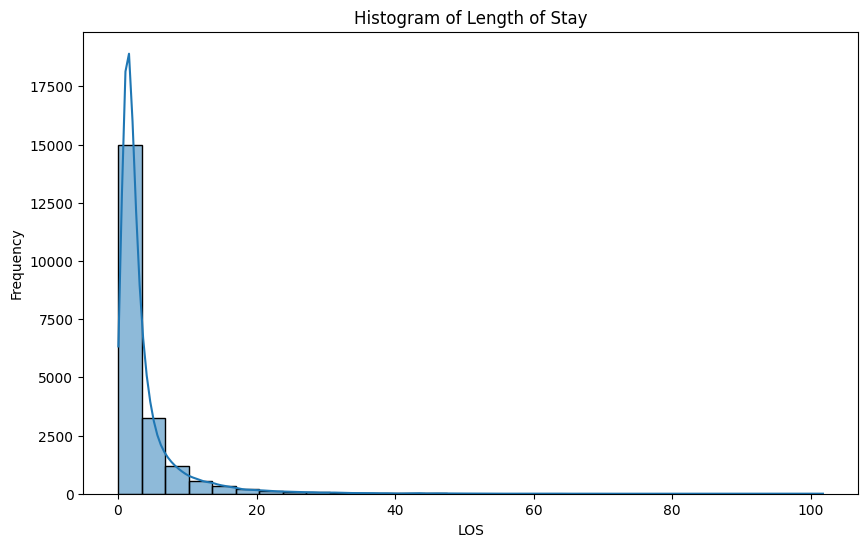

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df1['LOS'], bins=30, kde=True)
plt.title('Histogram of Length of Stay')
plt.xlabel('LOS')
plt.ylabel('Frequency')
plt.show()

### We will now test the same procedure with the log of the LOS as the target variable. The idea is that 'far away' observations could be making our model less robust. By transforming it to the log of the days, we would be assigning less weight to the big observations.

In [22]:
alphas_ridge = list(range(1,5000,50))
params_ridge = {'alpha': alphas_ridge}
grid_search_ridge = GridSearchCV(Ridge(), params_ridge, cv=6, scoring='neg_mean_squared_error', verbose=1)
grid_search_ridge.fit(X_train_scaled, log_y_train)
print("Best parameters:", grid_search_ridge.best_params_)
print("Best score (MSE):", -grid_search_ridge.best_score_)

Fitting 6 folds for each of 100 candidates, totalling 600 fits
Best parameters: {'alpha': 1801}
Best score (MSE): 0.4320146445394661


In [23]:
# KNN
param_grid_knn = {'n_neighbors': list(range(5,157,10)),
              'weights': ['uniform', 'distance']}
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=6, scoring='neg_mean_squared_error', verbose=1)
grid_search_knn.fit(X_train_scaled, log_y_train)
print(grid_search_knn.best_params_)
print("Best score (MSE):", -grid_search_knn.best_score_)

Fitting 6 folds for each of 32 candidates, totalling 192 fits
{'n_neighbors': 25, 'weights': 'uniform'}
Best score (MSE): 0.4649424162621039


In [24]:
# RANDOM FOREST
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 3, 5, 10, 20],
    'min_samples_leaf': [3, 10],
    'random_state': [42]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid_rf, cv=6, scoring='neg_mean_squared_error', n_jobs=6,verbose=1)
grid_search_rf.fit(X_train_scaled, log_y_train)
print("Best parameters found:", grid_search_rf.best_params_)
print("Best score (MSE):", -grid_search_rf.best_score_)

Fitting 6 folds for each of 30 candidates, totalling 180 fits
Best parameters found: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 400, 'random_state': 42}
Best score (MSE): 0.3764940903920735


In [25]:
base_learners = [
    ('Ridge', Ridge(alpha=1800)),
    ('KNN', KNeighborsRegressor(n_neighbors=25, weights='uniform')),
    ('RF', RandomForestRegressor(max_depth=None, min_samples_leaf=3, n_estimators=400))
]

meta_learner = GradientBoostingRegressor(random_state=42)

In [41]:
ensemble = StackingRegressor(estimators=base_learners, final_estimator=meta_learner, cv=5, verbose=1)
 # NJobs set to one; I was not able to predict on the np array
ensemble.fit(X_train_scaled, log_y_train)

y_pred = ensemble.predict(X_test_scaled)
y_pred = np.exp(y_pred)

In [ ]:
test_predictions_submit = pd.DataFrame({"icustay_id": test_df['icustay_id'], "LOS": y_pred})
test_predictions_submit.to_csv("Ensemble_pred.csv", index = False)

### Worsened the prediction, we will still use it in the NN implementation.

# Neural Network


In [21]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import initializers
from keras import regularizers
import tensorflow as tf

tf.random.set_seed(42)

## Keras
### Batch size, num of epochs, learning rate and the use of Early stopping + Dropout was tested on several tries for convergance which are not shown in the notebook.
#### We shall start with a simple model with two hidden layers and some regularization; the output layer in this case is a linear activation function as a first approach.

In [98]:
Keras_foo = Sequential([
      Dense(30,
             activation='relu',
             kernel_initializer=initializers.HeNormal(),
             activity_regularizer=regularizers.L2(1e-5)),
      Dropout(0.5),
      Dense(10, activation='relu'),
      Dense(1, activation='linear'),  # Output layer for positive LOS
])
Keras_foo.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')
history_foo = Keras_foo.fit(X_train_scaled, y_train_full,
                        epochs=100,
                        batch_size=20,
                        validation_split=0.15,
                        callbacks = EarlyStopping(monitor='val_loss', patience=5),
                        verbose=1)

Epoch 1/100
888/888 [==============================] - 1s 690us/step - loss: 2.5799 - val_loss: 2.2630
Epoch 2/100
888/888 [==============================] - 1s 568us/step - loss: 2.2930 - val_loss: 2.1113
Epoch 3/100
888/888 [==============================] - 1s 570us/step - loss: 2.1822 - val_loss: 2.0329
Epoch 4/100
888/888 [==============================] - 1s 568us/step - loss: 2.1095 - val_loss: 2.0080
Epoch 5/100
888/888 [==============================] - 1s 613us/step - loss: 2.0627 - val_loss: 1.9841
Epoch 6/100
888/888 [==============================] - 1s 573us/step - loss: 2.0337 - val_loss: 1.9691
Epoch 7/100
888/888 [==============================] - 1s 580us/step - loss: 2.0025 - val_loss: 1.9444
Epoch 8/100
888/888 [==============================] - 1s 605us/step - loss: 1.9835 - val_loss: 1.9281
Epoch 9/100
888/888 [==============================] - 1s 588us/step - loss: 1.9597 - val_loss: 1.9213
Epoch 10/100
888/888 [==============================] - 1s 571us/step - l

#### Plot of the loss (train and validation), the models appears to have converged.

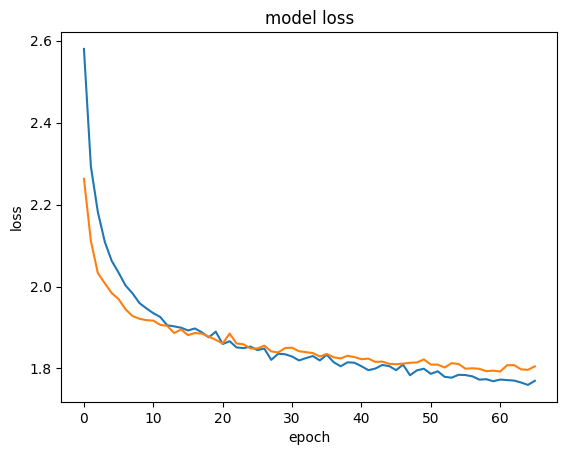

In [99]:
history_foo.history
plt.plot(history_foo.history['loss'])
plt.plot(history_foo.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### The out of sample accuracy is very poor, we try to improve by replacing the absolute loss to the square of the errors and also add another layer. Iterations, batch sizes and split are unchanged, they where chose upon several trial and errors tries.

In [95]:
Keras_MLP = Sequential([
      Dense(30, activation='relu', kernel_initializer=initializers.HeNormal()),
      Dropout(0.5),
      Dense(30, activation='relu'),
      Dense(10, activation='relu'),
      Dense(1, activation='linear'),  # Output layer for positive LOS
])


In [85]:
Keras_MLP.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [86]:
history = Keras_MLP.fit(X_train_scaled, y_train_full,
                        epochs=100,
                        batch_size=20,
                        validation_split=0.15,
                        callbacks = EarlyStopping(monitor='val_loss', patience=5),
                        verbose=1)


Epoch 1/100


888/888 [==============================] - 1s 817us/step - loss: 25.7041 - val_loss: 14.7956
Epoch 2/100
888/888 [==============================] - 1s 638us/step - loss: 14.7690 - val_loss: 13.4714
Epoch 3/100
888/888 [==============================] - 1s 643us/step - loss: 13.5375 - val_loss: 12.8341
Epoch 4/100
888/888 [==============================] - 1s 630us/step - loss: 13.0478 - val_loss: 12.4980
Epoch 5/100
888/888 [==============================] - 1s 632us/step - loss: 12.8686 - val_loss: 12.3666
Epoch 6/100
888/888 [==============================] - 1s 632us/step - loss: 12.5357 - val_loss: 12.1084
Epoch 7/100
888/888 [==============================] - 1s 631us/step - loss: 12.0990 - val_loss: 11.8962
Epoch 8/100
888/888 [==============================] - 1s 628us/step - loss: 12.3096 - val_loss: 11.7677
Epoch 9/100
888/888 [==============================] - 1s 690us/step - loss: 11.7286 - val_loss: 11.6303
Epoch 10/100
888/888 [==============================] - 1s 640us/st

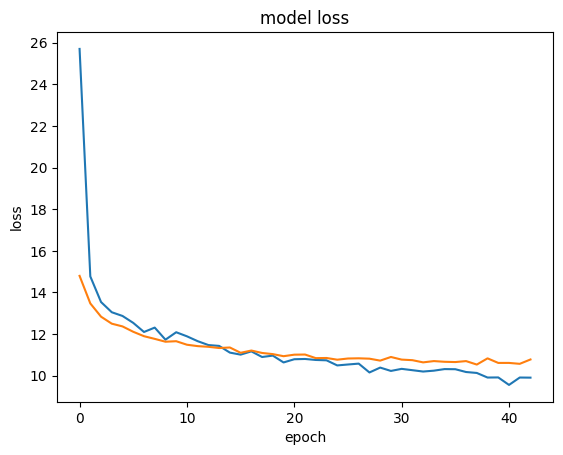

In [87]:
history.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### We now replace the final layer function to the exponential activation, more in line for what the prediction case involves (only positive and relatively small numbers). Also dropout and early stop in place, we extend the patience range to make the model more robust.

In [53]:
model = keras.Sequential([
      Dense(68, activation='relu',kernel_initializer=initializers.HeNormal()),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dense(1, activation='exponential')
  ])

model.compile(loss='mean_absolute_error',
            optimizer=Adam(learning_rate=0.001))

history = model.fit(X_train_scaled, log_y_train,
                        epochs=100,
                        batch_size=25,
                        validation_split=0.15,
                        callbacks = EarlyStopping(monitor='val_loss', patience=10),
                        verbose=1)


Epoch 1/100
711/711 [==============================] - 1s 462us/step - loss: 0.7037 - val_loss: 0.5960
Epoch 2/100
711/711 [==============================] - 0s 392us/step - loss: 0.6112 - val_loss: 0.5549
Epoch 3/100
711/711 [==============================] - 0s 391us/step - loss: 0.5760 - val_loss: 0.5404
Epoch 4/100
711/711 [==============================] - 0s 388us/step - loss: 0.5582 - val_loss: 0.5313
Epoch 5/100
711/711 [==============================] - 0s 392us/step - loss: 0.5391 - val_loss: 0.5288
Epoch 6/100
711/711 [==============================] - 0s 389us/step - loss: 0.5359 - val_loss: 0.5166
Epoch 7/100
711/711 [==============================] - 0s 394us/step - loss: 0.5243 - val_loss: 0.5389
Epoch 8/100
711/711 [==============================] - 0s 403us/step - loss: 0.5237 - val_loss: 0.5257
Epoch 9/100
711/711 [==============================] - 0s 393us/step - loss: 0.5180 - val_loss: 0.5132
Epoch 10/100
711/711 [==============================] - 0s 410us/step - l

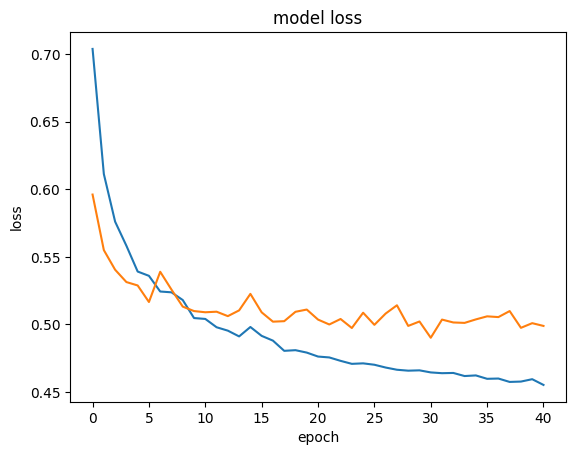

In [54]:
history.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Finally, small modification to the dropout and we introduce 'ReduceLROnPlateau' callback for another layer of flexibility on the learning rate. After 5 epochs with no improvement, it will cut down the Learning Rate 80% (only once) and continue iterating.
### This will be our best performing NN in the end.

In [22]:
model = Sequential([
    Dense(68, activation='relu', kernel_initializer=initializers.HeNormal()),
    Dropout(0.3),  # Reduced dropout rate
    Dense(64, activation='relu'),
    Dense(1, activation='exponential')  # Output layer for positive LOS predictions
])
model.compile(loss='mean_absolute_error',
              optimizer=Adam(learning_rate=0.001))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                              min_lr=0.0001, verbose=1)

# Train the model
history = model.fit(
    X_train_scaled, log_y_train,
    epochs=100,
    batch_size=20,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr],  # Add ReduceLROnPlateau to the callbacks
    verbose=1
)


Epoch 1/100
888/888 [==============================] - 1s 733us/step - loss: 0.6160 - val_loss: 0.5623 - lr: 0.0010
Epoch 2/100
888/888 [==============================] - 1s 605us/step - loss: 2.0720 - val_loss: 0.5486 - lr: 0.0010
Epoch 3/100
888/888 [==============================] - 1s 604us/step - loss: 0.5419 - val_loss: 0.5292 - lr: 0.0010
Epoch 4/100
888/888 [==============================] - 1s 610us/step - loss: 0.5346 - val_loss: 0.5229 - lr: 0.0010
Epoch 5/100
888/888 [==============================] - 1s 603us/step - loss: 0.5218 - val_loss: 0.5188 - lr: 0.0010
Epoch 6/100
888/888 [==============================] - 1s 602us/step - loss: 0.5140 - val_loss: 0.5095 - lr: 0.0010
Epoch 7/100
888/888 [==============================] - 1s 605us/step - loss: 0.5049 - val_loss: 0.5245 - lr: 0.0010
Epoch 8/100
888/888 [==============================] - 1s 609us/step - loss: 0.5141 - val_loss: 0.5150 - lr: 0.0010
Epoch 9/100
888/888 [==============================] - 1s 604us/step - l

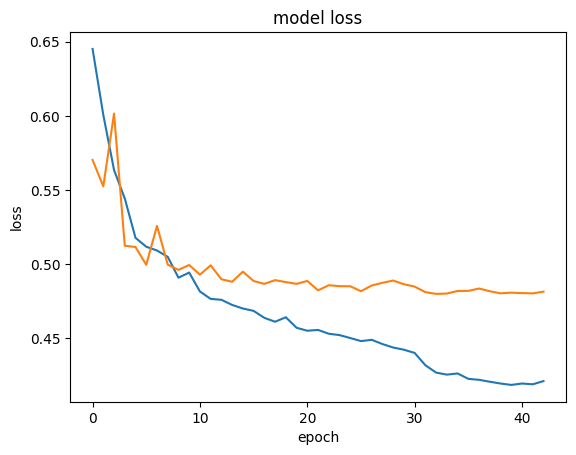

In [58]:
history.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


#### The model looks like converged and with early stopping we prevent overfitting. The loss is the minimum we could attain in this one compared to our previous attempts.

### Predict and submission.

In [184]:
log_y_pred = model.predict(X_test_scaled)
y_pred = np.expm1(np.squeeze(log_y_pred)) # Re transform for prediction.
test_predictions_submit = pd.DataFrame({"icustay_id": test_df['icustay_id'], "LOS": y_pred})
test_predictions_submit.to_csv("NN_pred.csv", index = False)

164/164 [==============================] - 0s 412us/step


# Model Interpretability
### Since we already grid searched for the best parameters in 3 models, we will pick one of the base learners (Random Forest) to use as the foundation of a Shaply Additive exPlanation run. 
Disclaimer: I was having issues trying to implement it for my final NN; so decided to do it on the RF.
#### Random Forest takes a very long time to run over the whole dataset so we subsample 30% of it. Since it is a random process, we should not be introducing bias in the result. We can observe that the most meaningful features are Diagnosis Codes such as {9,5,4,1} and numeric variables like temperature and Glucose. It is worth noting that this is an average of local effects for particular estimations and not the direct effects from the model itself; but provides valuable insight when analysing which features are relevant in our predictive exercise.

In [17]:
import shap 
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_scaled, log_y_train, test_size=0.7, random_state=42)

# Train the RandomForestRegressor on the subset
interpretation_rf = RandomForestRegressor(max_depth=None, min_samples_leaf=3, n_estimators=400, random_state=42)
interpretation_rf.fit(X_train_sub, y_train_sub)

# After training, use SHAP for interpretability
explainer = shap.TreeExplainer(interpretation_rf)
shap_values = explainer.shap_values(X_train_sub)

feature_importance = np.abs(shap_values).mean(axis=0) #axis=0 so the mean is calculated for the rows
feature_names = X_train_sub.columns
# Sort  by importance
sorted_feature_idx = np.argsort(feature_importance)[::-1]
# Slice most important ones
num_top_features = 10 
top_feature_idx = sorted_feature_idx[:num_top_features]


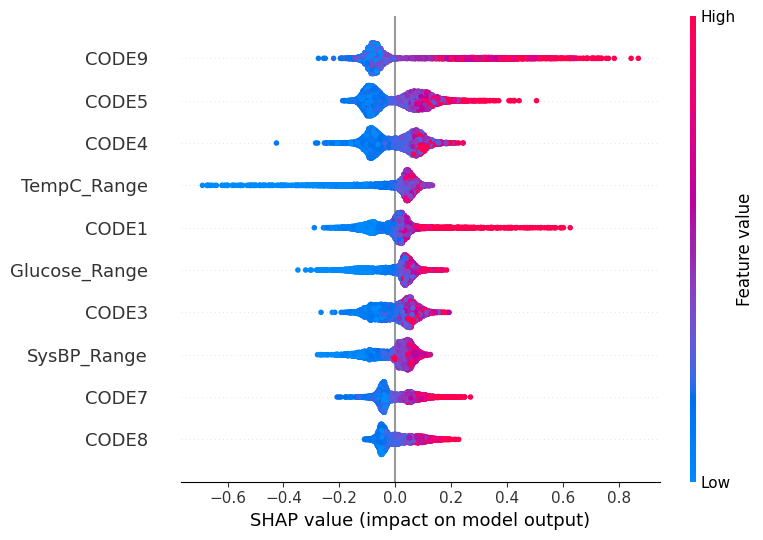

In [16]:
# Convert to NumPy array if X_train_sub is a DataFrame
X_train_sub_np = X_train_sub.to_numpy() if isinstance(X_train_sub, pd.DataFrame) else X_train_sub

# Now, when you're subsetting for the top features in SHAP or plotting,
# ensure you're using these NumPy arrays
shap.summary_plot(shap_values[:, top_feature_idx], X_train_sub_np[:, top_feature_idx],
                  feature_names=np.array(feature_names)[top_feature_idx])


# ----------------------------------------------------------

# In-class test #2

## Sklearn implementation of Neural Network

I don't erase it, but no actual changes where done in this later section of the notebook.

In [ ]:
# # I shall store 10% as test data to evaluate performance out of sample for the NN.
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train_full, test_size=0.1, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#### First NN setup: Using defaults for most of the parameters. The objective is to fit the model and reach convergance. After this is achieved, some tweaks will be done in order to improve the prediction power of the model.

#### All models will be initialized with random state 42 for reproducibility

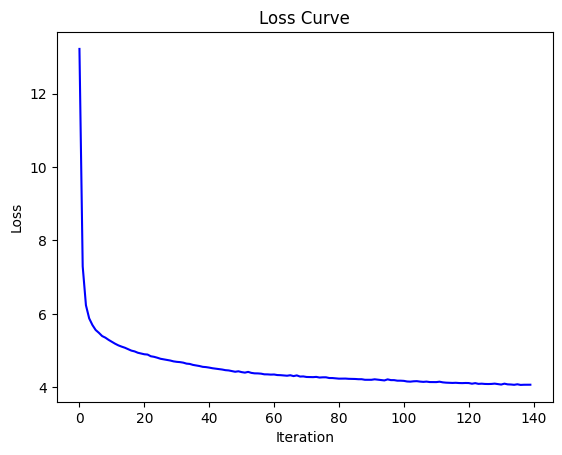

In [49]:
MLP_reg1 = MLPRegressor(activation='relu', 
                        solver='adam',
                        max_iter= 140,
                        random_state=42,
                        warm_start= False,
                        #verbose=1,
                        hidden_layer_sizes=(15,)
                         )
# Alpha, batch size, early stop, learning rate used defaults as first approach.
# Small network, 1 hidden layer with 15 nodes.

MLP_reg1.fit(X_train,y_train)
loss_curve = MLP_reg1.loss_curve_

plt.plot(loss_curve, color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

#### The loss curve seems to have found (or be near) a local minimun since the improvements are marginal and the curve flattens out.
Now, we shall specify parameters. The most relevant one is the use of early stopping

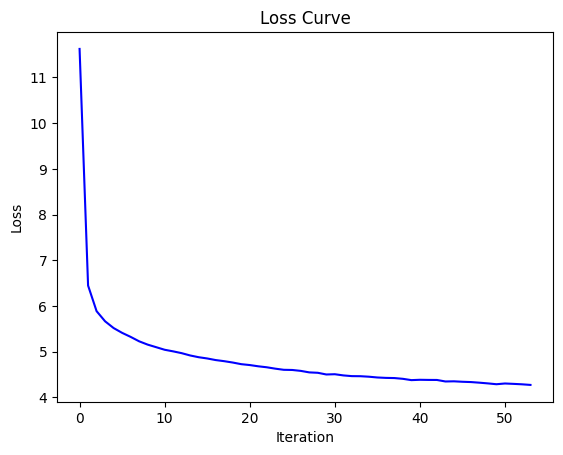

In [50]:
MLP_reg2 = MLPRegressor(activation='relu', 
                        solver='adam',
                        alpha=0.001,
                        batch_size=100,
                        learning_rate_init=0.001,
                        max_iter= 140,
                        random_state=42,
                        warm_start= False,
                        #verbose=1,
                        n_iter_no_change=10,
                        early_stopping=True,
                        hidden_layer_sizes=(15,)
                         )

MLP_reg2.fit(X_train,y_train)
loss_curve = MLP_reg2.loss_curve_

plt.plot(loss_curve, color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

#### The fact that early stopping was triggered helps us regularize the model and try to prevent overfitting. This means that the 'Validation score' for the epoch has not improved (more than .0001) for 10 consecutive iterations; from training in 90% of the batch data and testing in the remaining 10%. This can be thought as a measure of the real predictive power of our NN. Hopefully at this point we have a good tradeoff between bias and variance. The Loss function still decreases for further iteration although this might be due to increasing overfit on the training dataset.

In [51]:
alpha_values = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]

# Alphas to try
param_grid = {
    'alpha': alpha_values
}
# For root mean square error evaluation 
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)


grid_search1 = GridSearchCV(estimator=MLP_reg2, param_grid=param_grid, 
                           scoring=rmse_scorer,  # Use the custom RMSE scorer
                           cv=5,
                           verbose=1)

In [52]:
grid_search1.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=MLPRegressor(alpha=0.001, batch_size=100,
                                    early_stopping=True,
                                    hidden_layer_sizes=(15,), max_iter=140,
                                    random_state=42),
             param_grid={'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]},
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
             verbose=1)

In [53]:
print("Best parameters found: ", grid_search1.best_params_)
print("Best RMSE found: ", np.sqrt(-grid_search1.best_score_))

Best parameters found:  {'alpha': 0.001}
Best RMSE found:  1.7955056904124258


### We got that the best alpha is 0.1 , we now fit the previous network with that regularization parameter and check RMSE out of sample. This will be our final model with the original setup.

Although 0.1 is a corner solution in our grid search, we saw in class that the reasonable values for alpha range from: [1.e-06, 1.e-01]. Therefore, i will not try higher values in this case.

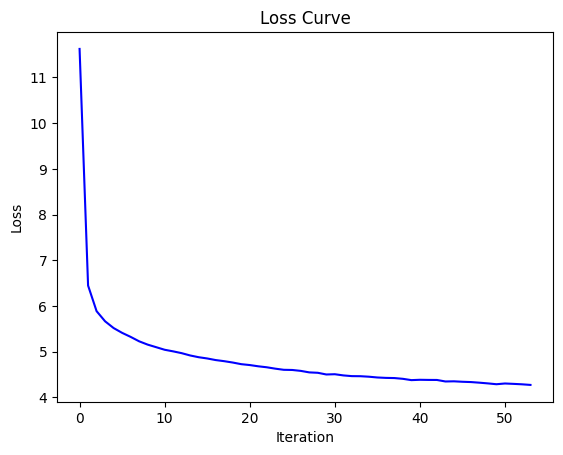

In [55]:
MLP_reg3 = MLPRegressor(activation='relu', # CV is only done for alpha, everything else holds constant.
                        solver='adam',
                        alpha=0.001,
                        batch_size=100,
                        learning_rate_init=0.001,
                        max_iter= 140,
                        random_state=42,
                        warm_start= False,
                        #verbose=1,
                        n_iter_no_change=10,
                        early_stopping=True,
                        hidden_layer_sizes=(15,)
                         )

MLP_reg3.fit(X_train,y_train)
loss_curve = MLP_reg3.loss_curve_

plt.plot(loss_curve, color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

In [56]:
y_hat1 = MLP_reg3.predict(X_test)

rmse1 = np.sqrt(mean_squared_error(y_test, y_hat1))

print("RMSE:", rmse1)


RMSE: 2.986361356405138


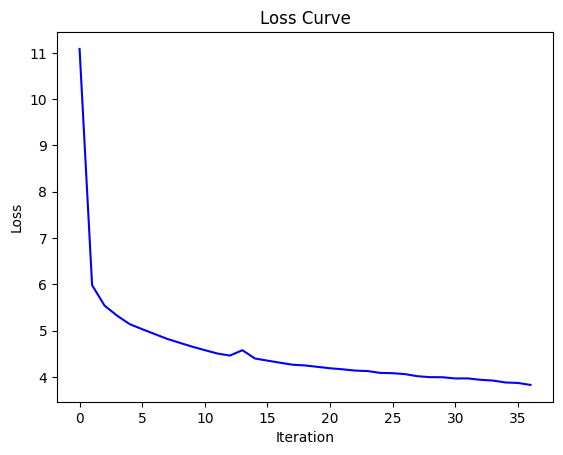

In [57]:
MLP_reg4 = MLPRegressor(activation='relu', # CV is only done for alpha, everything else holds constant.
                        solver='adam',
                        alpha=0.1,
                        batch_size=100,
                        learning_rate_init=0.001,
                        max_iter= 140,
                        random_state=42,
                        warm_start= False,
                        #verbose=1,
                        n_iter_no_change=10,
                        early_stopping=True,
                        hidden_layer_sizes=(25,10)
                         )

MLP_reg4.fit(X_train,y_train)
loss_curve = MLP_reg4.loss_curve_

plt.plot(loss_curve, color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

In [58]:
y_hat2 = MLP_reg4.predict(X_test)

rmse2 = np.sqrt(mean_squared_error(y_test, y_hat2))

print("RMSE:", rmse2)

RMSE: 2.990972888894994


In [59]:
MLP_reg4.fit(X_train_scaled,y_train_full)

MLPRegressor(alpha=0.1, batch_size=100, early_stopping=True,
             hidden_layer_sizes=(25, 10), max_iter=140, random_state=42)

### Since the MLP4 got better MSE we will use that one. When i tried with the more complex model I obtained a much better metric, therefore i will keep this later one as the final one.

In [62]:
y_hat_NN = MLP_reg4.predict(X_test_scaled)
test_predictions_submit = pd.DataFrame({"icustay_id": test_df['icustay_id'], "LOS": y_hat_NN})
test_predictions_submit.to_csv("NN_pred.csv", index = False)

In [61]:
y_hat_NN

array([3.75403935, 5.48791752, 2.54254745, ..., 1.7771087 , 1.73510515,
       1.09668425])